# **To-Do Tasks**

* Tell Haas there was a planar graph generated that suffices for the paper
* Include Haas recommendations for GSMP specification at top
* Remove source/sink node options for graph creation, or add in trimmed possibility from before. Could name the new/current graph generation mode "restorative" and add a boolean value in graph params
* Graph parameter section- add option to either manually set or randomize number of nodes (max of say, 200?)
* Check to make sure proper implementation of exponential distribution


# Assembly Line GSMP

## **GSMP Definition** 
###**State Space**
$ S \in \{(M_0, M_1, \dots, M_n)\} = \{ \{A(M_0)\}, \{A(M_1), B_0, B_1, \dots B_{J1}\}, \dots \{A(M_n), B_0, B_1, \dots B_{Jn}\}\} \\ \in 
\{\{1\}\} \times \{\{0, 1\} \times \{ 0, 1,\dots, U\}_0 \dots \{0, 1,\dots, U\}_{J1}\} \times \dots \{\{0, 1\} \times \{0, 1,\dots, U\}_0 \dots \{0, 1,\dots, U\}_{Jn}\}$

* $M_i$ represents a production node with $J$ incoming edges. Its state space is $\{A(M_i), B_0, B_1, \dots B_{Ji}\}$ which represents whether it is actively producing and the number of parts acquired in each bin, with each corresponding to all $J$ incoming edges. $A(M_i)$ is 1 if currently producing and 0 if idle/waiting for parts. There is a universal maximum cap of $U$ number of parts for every bin.


### **Events**

${e_0} \in E(s)$ 
* $ e_0 $ is the event representing the part completion for the source production node (marked node zero), this event can always occur.

$e_{i} \in E(s)$ if  $\sum_{j=0}^{J} I(B_j, M_i) == J$ with indicator function $I(B_j, M_i) == 1$ if bin $B_j \geq 1 $ for node $M_i$
* Node $M_i$ can only begin production once all J of its required parts are available.



### **Transition probabilities**
$N(s, M_i)$ = $\sum_{j=0}^{n} I(s)$ with indicator function $I(s)$ == 1 if $M_i$ has an outgoing edge to $M_j$.
* This function totals all outgoing edges from arbitrary node $M_i$.

$ p(s', s, e_i) = 1/N(s)$ with $s = (M_0(t), \dots, M_n(t))$ having an $M_i = (A(M_i), B_{0}, B_{1}, \dots, B_{Ji})$ with an $A(M_i) = 1$ and an $M_j = (A(M_j), B_{0}, B_{1}, \dots, B_{Jj})$ with a $B_j = k$. The new state $s'$ has an $M_i = (A(M_i), B_{0}, B_{1}, \dots, B_{Ji})$ with an $A(M_i) = 0$ and an $M_j = (A(M_j), B_{0}, B_{1}, \dots, B_{Jj})$ with a $B_j = k + 1$.
* Upon node $M_{i}$'s completion of a new part (event $e_i$), node $M_i$ is marked as deactivated and then each of the nodes that has an incoming connection from $M_i$ has equal chance of being selected. On selection, the chosen node $M_j$ has the bin corresponding with $M_i$ incremented by 1.

$p(s', s, e_0) = 1$ with $s = (M_1(t), \dots, M_n(t))$ having an $M_i = (0, k_0, k_1, \dots k_J)$ and $s' = (M_1(t),\dots, M_n(t))$ having an $M_i = (1, k_0-1, k_1-1, \dots k_J-1)$
* Once an inactive node $M_i$ has at least 1 in all of its bins it is certain to become active and have all of its bins decremented by 1.




### **Clock Distribution Timers**

$F(x; s', e', s, e^*) = F_p(x)$ with $F_p(x) = 1 - e^{-1/\beta x}$ being an exponential process with an average time of β minutes. 



### **Rate**

$r(s, e) = 1$ for all $s$ and $e$



## **Initial distribution**
$V(s_0) = \{M_0(0), M_1(0), \dots, M_n(0)\} = \{(A(M_0), (A(M_1), B_0, B_1, \dots, B_{J1}), \dots (A(M_n), B_0, B_1, \dots, B_{Jn})\} = \{\{1\}, \{0,0 \dots 0\}, \dots \{0,0 \dots 0\}\}$


* Start with nothing produced, where all nodes $M_i$ require each of its $J_i$ bins $\geq 1$ to begin production. Note that every Node $M_i$ has a different number of incoming edges, so every $J_i$ varies per node. The source node $M_0$ is always producing and has no incoming edges, hence A(0) is always 1 and it has no bins.


$F(x; e_0, s_0) = F_{p}(x)$ defined above

# Setup

## Mount to Drive

In [ ]:
%reload_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount("/content/drive/")
%cd /content/drive/MyDrive/Colab Notebooks/SQN Project/

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/SQN Project


## Imports and Boiler Plate

In [ ]:
import math
import rngStream
import heapq # Python heap data structure
import json
import copy # Necessary for deepcopy, which is required for state history.

import networkx as nx
from traitlets.traitlets import List # Allows type-checking, might be useful for cython?
!pip3 install queueing_tool
import queueing_tool as qt
!pip3 install simpy

from scipy.stats import norm # normal distribution for CIs, required for estimator. REMOVE if removing estimator.
import matplotlib.pyplot as plt
from main import random_queueing_network, create_dataset

import numpy as np
np.set_printoptions(suppress=True, precision=4, floatmode='fixed') # beautiful option to set number of trailing digits to 4. Doesn't even perform a round operation.
np.seterr(invalid='ignore')

<frozen importlib._bootstrap>:219: RuntimeWarning: compiletime version 3.6 of module 'rngStream' does not match runtime version 3.8


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 269 kB 50.2 MB/s 
  Created wheel for queueing-tool: filename=queueing_tool-1.2.4-cp38-cp38-linux_x86_64.whl size=602725 sha256=3ecce17179409000f358e1be624117c4959817e1bf9625916a66f0f9aaa708a2
  Stored in directory: /root/.cache/pip/wheels/63/d5/6e/8f38d6ae817468eee7d96bfae0357f61ab1ea9b3ca288d59df
Successfully built queueing-tool
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
seed0 = [12345, 12345, 12345, 12345, 12345, 12345]
rngStream.SetPackageSeed(seed0)

## Define EventList

In [ ]:
class EventList:
    """Event list using a heap data structure"""
    def __init__(self):
        self.event_list = []  # heap containing [time, event_id] pairs
        self.event_record = {}  # dictionary with key = event_id, val = ptr into heap
                                # (used for cancellation)

    def add_event(self, event_id, time):
        """Adds event_id with time (should be a float) in the event list"""
        if type(event_id) == list: # convert to csv string
            event_id = ",".join([str(i) for i in event_id]) 
        if event_id in self.event_record:
            self.cancel_event(event_id)
        new_event = [time, event_id]
        self.event_record[event_id] = new_event
        heapq.heappush(self.event_list, new_event)

    def cancel_event(self, event_id):
        """Cancels event having id = event_id"""
        if type(event_id) == list: # convert to csv string
            event_id = ",".join([str(i) for i in event_id]) 
        if event_id in self.event_record:
            to_remove = self.event_record.pop(event_id)
            to_remove[-1] = "<canceled>"
        else:
            raise KeyError("Event %s not in list." %str(event_id))

    def next_event(self):
        """Return (event_id, time) tuple if event_id is int or string"""
        if self.event_list:
            next_event = heapq.heappop(self.event_list)
            if next_event[-1] != "<canceled>":
                del self.event_record[next_event[-1]]
                return next_event[-1], next_event[0]
            return self.next_event()
        else:
            raise KeyError("Popping from an empty event list.")

    def next_event_LI(self):
        """Return (event_id, time) tuple if event_id is list of ints"""
        eid, t = self.next_event()
        eid = [int(x) for x in eid.split(',')]
        return [eid, t]
        
    def reset(self):
        self.event_list = []
        self.event_record = {}

    def __str__(self):
        el = sorted(self.event_list)
        return "\n".join([str(x) for x in el])

#Graph

## Graph Parameters

In [ ]:
# https://colab.research.google.com/notebooks/forms.ipynb
# Number of nodes 
debug = 2 #@param {type:"slider", min:0, max:3, step:1}
n = 4  #@param {type:"integer"}
# When source is true it will remove all non-numerically-zero source nodes
source = True #@param {type: "boolean"}
# When sink is true it will remove all sink nodes except the final node
sink = True #@param {type: "boolean"} 

## Initial Generated Graph

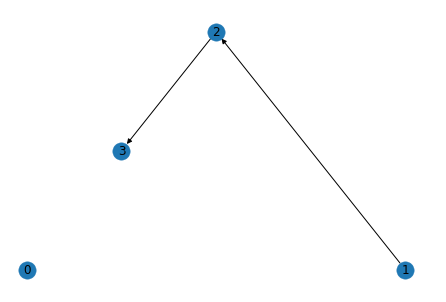

In [ ]:
G = nx.DiGraph()
G.add_nodes_from([i for i in range(n)])
unigen = rngStream.RngStream('Uniform Stream')
# print(G.nodes.data()) # check color property
# Every node can have an outgoing edge to a numerically-larger node
for j in range(n):
  for k in range (j + 1, n):
    u = unigen.RandU01()
    if u > 0.5:
      G.add_edge(j, k)  # Add edge between node j and node k

# nx.draw_planar(G, with_labels = True, node_color = 'red')      
nx.draw_planar(G, with_labels = True)

## Restructure Function

In [ ]:
def print_state(G):
  for node in G.nodes:
    print(f"Node {node} out-degree: {G.out_degree(node)}, in-degree {G.in_degree(node)}")
  print()

In [ ]:
U = rngStream.RngStream("Restructure Stream")
def restructure(G):
  for node in list(G.nodes):
    if (G.in_degree(node) < 1 and node != 0):
      print(f"Node: {node}, selecting from {range(0, node - 1)}")
      u = U.RandU01()
      sel = math.floor( u * len(range(0, node)) )
      print(f"U: {u}, Sel: {sel}")
      # selected = math.floor(U.RandU01() * len(range(0, node)))
      print(f"Number predecessors: {len(range(0, node))}, selecting node {sel}\n")
      G.add_edge(sel, node)

    if (G.out_degree(node) < 1 and node != n-1):
      min = node + 1
      print(f"Node: {node}, selecting from {range(min, n - 1)}")
      u = U.RandU01()
      sel = math.floor(min + u * len(range(node+1, n - 1)) )
      print(f"U: {u}, Sel: {sel}")
      # selected = math.floor(U.RandU01() * len(range(node + 1, n - 1)))
      print(f"Number predecessors: {len(range(0, node))}, selecting node {sel}\n")
      G.add_edge(node, sel)

##Final Graph

Node 0 out-degree: 0, in-degree 0
Node 1 out-degree: 1, in-degree 0
Node 2 out-degree: 1, in-degree 1
Node 3 out-degree: 0, in-degree 1

Node: 0, selecting from range(1, 3)
U: 0.7595818622487196, Sel: 2
Number predecessors: 0, selecting node 2

Node: 1, selecting from range(0, 0)
U: 0.9783105732613708, Sel: 0
Number predecessors: 1, selecting node 0

Node 0 out-degree: 2, in-degree 0
Node 1 out-degree: 1, in-degree 1
Node 2 out-degree: 1, in-degree 2
Node 3 out-degree: 0, in-degree 1



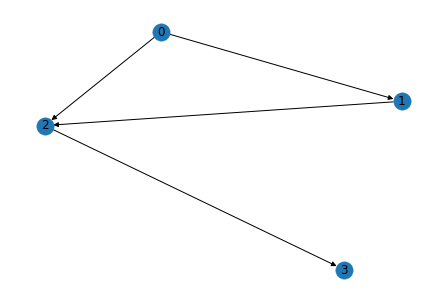

In [ ]:
print_state(G)
restructure(G)
print_state(G)
nx.draw(G, with_labels = True)

The Graph is planar


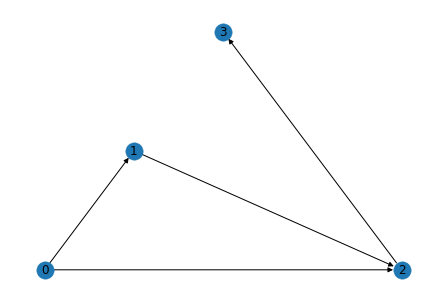

In [ ]:
# Note, could use this for paper. 
try:
  nx.draw_planar(G, with_labels = True)
  print("The Graph is planar")
except:
  print("The graph is not planar")

In [ ]:
nx.get_node_attributes(G, "color")
print(G.edges.items())
print(G.edges.values())

ItemsView(OutEdgeView([(0, 2), (0, 1), (1, 2), (2, 3)]))
ValuesView(OutEdgeView([(0, 2), (0, 1), (1, 2), (2, 3)]))


#Simulation

## Constants and Helper Functions

In [ ]:
beta = 0.5 # Edit to influence poisson

# TO-DO: Check logic for exponential is correct distribution. ***
def exponential(stream: rngStream.RngStream):
  U = stream.RandU01()
  return -beta * math.log(U) # Inverse of exponential CDF

def clock_generation(t, stream: rngStream.RngStream):
  return t + exponential(stream)

def verbose_print(level, *args):
    if level <= int(debug):
        for arg in args:
            print(arg, end=' ')
    else:
        pass

In [ ]:
# Returns number of nodes in a networkx graph
def get_num_nodes(G):
  verbose_print(1, f"\nNum nodes function\n")
  NUM_NODES = len(G)
  verbose_print(1, f"Num nodes: {NUM_NODES}\n")
  return NUM_NODES

# Returns the bin size for every node given a list of every node's edges
def get_num_bins(edge_list: List):
  verbose_print(1, "\nGet num bins function\n")
  verbose_print(2, edge_list, "\n")
  verbose_print(3, f"Edge list: {edge_list}\nType: {type(edge_list)} of {type(edge_list[0])}")
  
  num_bins = []
  for edges in edge_list:
    num_bins.append(len(edges))
  verbose_print(2, "Num bins:", num_bins,"\n")

  # Convert from list to tuple
  num_bins = tuple(num_bins)
  verbose_print(1, "Num bins:", num_bins,"\n")
  return num_bins

# Returns the list of outgoing edges for every node (A list of lists) given a networkx graph
def get_outgoing_edges(G):
  verbose_print(1, "\nOutgoing edges function\n")
  dic_list_adj = nx.convert.to_dict_of_lists(G)
  verbose_print(3, type(dic_list_adj), type(dic_list_adj[0]), "\n")
  verbose_print(2, dic_list_adj, "\n")

  outgoing_edges = []
  for k,v in dic_list_adj.items():
    verbose_print(2, k, v, "\n")
    outgoing_edges.append(v)
  verbose_print(2, f"Outgoing edges: {outgoing_edges}\n")

  # Convert from list of lists to list of tuples
  for i, node in enumerate(outgoing_edges):
    outgoing_edges[i] = tuple(node)
  verbose_print(1, f"Outgoing edges: {outgoing_edges}\n")
  return outgoing_edges

# Returns a list of incoming edges for every node. Using networkx is futile. Instead, reverse-engineer the outgoing edges list to generate this list.
def get_incoming_edges(outgoing_edges:List):
  verbose_print(1, "\nIncoming edges function\n")
  verbose_print(3, "Parameter outgoing edges:", outgoing_edges)
  incoming_edges = [[] for x in range(len(outgoing_edges))]
  verbose_print(3, f"Incoming edges empty {incoming_edges}")

  for i, node in enumerate(outgoing_edges):
    verbose_print(3, f"\nI: {i}, Node {node}\n")
    for connection in node:
      incoming_edges[connection].append(i)
      verbose_print(2, f"Noted node {i} as connected to {connection}\n")
  verbose_print(2, f"Incoming edges: {incoming_edges}\n")

  # Convert from list of lists to list of tuples
  for i, node in enumerate(incoming_edges):
    incoming_edges[i] = tuple(node)
  verbose_print(1, f"Incoming edges: {incoming_edges}\n")
  return incoming_edges

# Returns an "output map" that specifies, for every output node with outgoing edges, the correct bins for input nodes connected to that output node.
def get_output_map(incoming_edges, outgoing_edges, NUM_BINS):
  verbose_print(1, "\nOutput map function\n")
  verbose_print(2, "\nIncoming edges: ", incoming_edges, "\nOutgoing edges: ", outgoing_edges, "\n")

  outmap = [[] for x in range(len(outgoing_edges))]
  for out_index, node in enumerate(outgoing_edges):
    for out_edge_val in node:
      verbose_print(2, "\nOutput edge value:", out_edge_val)
      verbose_print(2, f"Incoming edges of node {out_edge_val} are: {incoming_edges[out_edge_val]}")

      bin_index = 0
      for in_edge in incoming_edges[out_edge_val]:
        verbose_print(3, "Cumulative (counting) bin index: ", bin_index)
        if in_edge == out_index:
          verbose_print(2, f"\nIncoming node {out_edge_val} has bin index {bin_index} corresponding to outgoing node {out_index}")
          break
        bin_index += 1
      if(bin_index >= 0):
        outmap[out_index].append((out_edge_val, bin_index))
  verbose_print(2, "\n")
  verbose_print(1, f"Output map: {outmap}\n")
  return outmap

## Simulation Model

In [ ]:
class SQN_Model:
  def __init__(self, NUM_NODES, NUM_BINS, MAX_BIN, MAX_TIME, OUTPUT_MAP):
    self.unigens = {}
    self.unigens["Generation Timer"] = [rngStream.RngStream() for node in range(NUM_NODES)] # N timer for next completion event
    self.unigens["Output selection"] = [rngStream.RngStream() for node in range(NUM_NODES)] # N timers for selecting which node to output to
    self.N = NUM_NODES
    self.J = NUM_BINS
    self.U = MAX_BIN
    self.T_MAX = MAX_TIME # TO-DO: Rename everything referencing this to "MAX_TIME" as timesteps is misleading
    self.state_history = []
    self.output_map = OUTPUT_MAP
    self.MM1_verif = []
    self.L_TMAX = -69999

  def get_final_queue_size(self):
    return self.L_TMAX
  
  def get_MM1_verification(self):
    return self.MM1_verif

  # Prints out the state, time, and trigger event.
  def print_sc(self, state, time, i, m):
    """ Format state, clocks, and trigger event for printing """
    sstr = '('+ str([''.join(str(x)) for x in state]) + ')'
    event_names = ["generation timer", "output selection"]
    eventstr = f"Event: {event_names[m]}" if m >= 0 else ""
    istr = "i* = {:2d}".format(i) if i >= -1 else ""
    mstr = "m* = {:2d}".format(m) if m >= 0 else ""
    tstr = "T = {0:8.4f}".format(time)
    outstr = "\n{}: {} {} {} {}\n".format(tstr, sstr, istr, mstr, eventstr)
    print(outstr)
    return outstr

  # This output looks at the possible incoming edges to the output node and selects one randomly using the output_map data structure.
  def choose_output(self, node):
    verbose_print(2, "Choose output function\n")
    # This chooses a random outgoing edge from an output node, then increments the corresponding bin within the chosen input node.
    u = self.unigens["Generation Timer"][node].RandU01()
    index = math.floor(u * (len(self.output_map[node])))
    # DEBUG 10/21 print(f"index {index}")
    try:
      verbose_print(3, f"Uniform: {u}, number of connected nodes {len(self.output_map[node])}, index #{index} was selected\n")
      verbose_print(3, f"Output map: {self.output_map}\n")
      verbose_print(1, f"Options: {self.output_map[node]}, Selection: node {self.output_map[node][index][0]} bin {self.output_map[node][index][1]}\n")
      return self.output_map[node][index][0], self.output_map[node][index][1]

    except:
      verbose_print(3, "Trivial node example")

  # This function changes s' to be equal to s without memory allocation. Used at the end of state transition steps.
  def state_swap(self, s:List, s_prime:List):
    if debug > 0:  # TO-DO: REMOVE ON CORRECT OUTPUT
      assertion_id = id(s)
    for index, x in enumerate(s_prime):
      for x_i in range(len(x)):
        s[index][x_i] = s_prime[index][x_i]
    if debug > 0:  # TO-DO: REMOVE ON CORRECT OUTPUT 
      assert(id(s) != id(s_prime)) 
      assert(id(s) == assertion_id)

  # This function checks if a node has ALL of its input bins filled. If they do, then True is returned, else False.
  def check_ready_fire(self, node):
    all_true = True
    for bins in node[1:]:
      if bins < 1:
        all_true = False
    return all_true
  
  # This function decrements 1 from every bin.
  def decrement_bins(self, state, node_index):
    verbose_print(3, f"Decrementing bins of node {node_index}. Before: {state[node_index]}, ")
    for index, bin_val in enumerate(state[node_index][1:]):
      state[node_index][index + 1] -= 1
    verbose_print(3, f"after: {state[node_index]}\n")
    
  # Runs an episode/trial of the simulated SQN
  def do_rep(self, include_state_history=True, include_throughput=True, include_activityrate=False, MAX_TRANSITIONS = 0):
    # Setup simulation variables
    state = [[0] * (J_i + 1) for J_i in self.J]
    state[0][0] = 1 # To show that node 0 is always active.
    state_prime = state.copy() # This is a deep copy.
    event_list = EventList()
    time = 0.0
    timestep = 0
    num_transitions = 0
    holding_times = []
    costs = []
    state_hist = [(state, 0.0, None)] # History of all states throughout every transition in [state, time, event_trigger] format.

    PE_throughput = 0 # point estimate. Only added to final output if flag is raised.
    PE_expectedActiveNodes = 0 # point estimate. Only added to the final output if flag is raised.
    Num_nodes_active = 1 # Always 1, because of the source node.

    # Schedule first generation through source node, # TO-DO: Make sure this is included in the total time calculation
    first_timer = clock_generation(time, self.unigens["Generation Timer"][0])
    event_list.add_event(event_id=[0, 0], time=first_timer)
    verbose_print(1, f"Initial State: {state}\n")
    verbose_print(1, f"Output map {self.output_map}\n")

    # MAX_TIMESTEPS route for completion. The simulation will end when the max_timesteps number is reached.
    # print(f"MAX TRANSITIONS: {MAX_TRANSITIONS}")
    if MAX_TRANSITIONS:
      # Continue simulation until max timesteps (self.T_MAX) TO-DO: Change to cumulative time instead of max timesteps.
      while timestep < MAX_TRANSITIONS:

        # Edge case: Check if source node has no outgoing edges # DEBUG ADDITION 10/20
        if len(self.output_map[0]) == 0: # If source node has no outgoing edges
          verbose_print(1, f"\nTimestep {timestep}, initial time {time}\n")
          event_id, tprime = event_list.next_event_LI()
          # self.MM1_verif.append(state_prime[0][bin + 1]) //Unneccesary for this edge case.
          outnode_index = event_id[0]
          verbose_print(1, f"Event e{outnode_index} new output from node {outnode_index}, tprime = {tprime}\n")
          
          PE_throughput += 1        
          # Set new clocks for source node.
          newtimer = clock_generation(tprime, self.unigens["Generation Timer"][0])
          event_list.add_event(event_id=[0], time=newtimer) # Add timer for [node 0, soon-to-be-trigger-event 0]
          verbose_print(1, f"Set a future timer for e{outnode_index}: {newtimer}\n")

          # Print new state (Should trivially be the same as past state)
          verbose_print(1, f"New state: {state_prime}\n")
          # Check end condition (TO-DO: Necessary for making it time based as opposed to timestep based)
          timestep += 1 # Decrement down each time step, remove when finished.

          self.state_swap(state, state_prime) # TO-DO: Make sure state_swap works here.
          # temp_history_state = state.copy() # TO-DO: Include in presentation slide.
          temp_history_state = copy.deepcopy(state)
          self.state_history.append((temp_history_state, tprime, outnode_index)) # Note, outnode_index is the trigger event.
          time = tprime
          continue # DEBUG ADDITION 10/20


        # This runs for non-edgecases situations, with there being >1 nodes:
        verbose_print(1, f"\nTimestep {timestep}, initial time {time}\n")
        event_id, tprime = event_list.next_event_LI()
        outnode_index = event_id[0]
        verbose_print(1, f"Event e{outnode_index} new output from node {outnode_index}, tprime = {tprime}\n")

        # Check if trigger event was output node generation was from the final sink node (no outgoing edges) DEBUG 10/21
        # If so, avoid selecting input node as that will cause an error.
        if outnode_index == self.N - 1:
          verbose_print(1, f"SINK node has 'generated' an output. Throughput incremented, new value {PE_throughput+1}\n") ##########DEBUG
          PE_throughput += 1

          # Deactivate output node. Check if it requalifies for re-activation, if so schedule event. It's NOT necessary to check downstream activations.
          state_prime[outnode_index][0] = 0
          verbose_print(1, f"Deactivated node {outnode_index}\n")
          if self.check_ready_fire(state_prime[outnode_index]):
            state_prime[outnode_index][0] = 1
            verbose_print(1, f"Activated node {outnode_index}\n")
            newtimer = clock_generation(tprime, self.unigens["Generation Timer"][outnode_index])
            event_list.add_event(event_id=[outnode_index], time=newtimer) # Add timer for [node 0, soon-to-be-trigger-event 0]
            verbose_print(1, f"Set a future timer for e{outnode_index}: {newtimer}\n")
            self.decrement_bins(state, outnode_index)

        # Trigger event was NOT from the final sink node, and thus there will be an input node.
        else:
          # Increment a corresponding input node/bin connected to the output node
          innode_index, bin = self.choose_output(outnode_index) # This returns the input node and bin selected among the output node's outgoing edges.
          if state_prime[innode_index][bin + 1] >= MAX_BIN:
            verbose_print(1, f"Input node {innode_index} has reached the max bin size of {MAX_BIN}")
          else:
            state_prime[innode_index][bin + 1] += 1
          verbose_print(3, f"Transitionary bin-increment state: {state_prime}\n")
          
          # Set the new clock(s)
          # If trigger event was source node generation reset source node timer and check downstream activations for new clocks
          if outnode_index == 0:
            newtimer = clock_generation(tprime, self.unigens["Generation Timer"][0])
            event_list.add_event(event_id=[0], time=newtimer) # Add timer for [node 0, soon-to-be-trigger-event 0]
            verbose_print(1, f"Set a future timer for e{outnode_index}: {newtimer}\n")

            # Check whether trickle down node is active, just activated and requires event scheduling, or still inactive
            if state_prime[innode_index][0] < 1: # Check whether the input node is set to active
              if self.check_ready_fire(state_prime[innode_index]): # Check whether it is NOW activatable
                state_prime[innode_index][0] = 1
                Num_nodes_active += 1 # For expected value of number of nodes currently active
                verbose_print(1, f"Activated node {innode_index}\n")
                newtimer = clock_generation(tprime, self.unigens["Generation Timer"][innode_index])
                event_list.add_event(event_id=[innode_index], time=newtimer) # Add timer for [node 0, soon-to-be-trigger-event 0]
                verbose_print(1, f"Set a future timer for e{innode_index}: {newtimer}\n")
                self.decrement_bins(state, innode_index)
          
          # Otherwise deactivate output node, check if it requalifies for re-activation, then check downstream activations
          else:
            state_prime[outnode_index][0] = 0
            Num_nodes_active -= 1 # For expected value of number of nodes currently active

            verbose_print(1, f"Deactivated node {outnode_index}\n")
            if self.check_ready_fire(state_prime[outnode_index]):
              state_prime[outnode_index][0] = 1
              Num_nodes_active += 1 # For expected value of number of nodes currently active

              verbose_print(1, f"Activated node {outnode_index}\n")
              newtimer = clock_generation(tprime, self.unigens["Generation Timer"][outnode_index])
              event_list.add_event(event_id=[outnode_index], time=newtimer) # Add timer for [node 0, soon-to-be-trigger-event 0]
              verbose_print(1, f"Set a future timer for e{outnode_index}: {newtimer}\n")
              self.decrement_bins(state, outnode_index)

            # Check whether the downstream input node is active, just activated and requires event scheduling, or still inactive
            if state_prime[innode_index][0] < 1: # Check whether the input node is set to active
              if self.check_ready_fire(state_prime[innode_index]):
                state_prime[innode_index][0] = 1
                Num_nodes_active += 1 # For expected value of number of nodes currently active

                verbose_print(1, f"Activated node {innode_index}\n")
                newtimer = clock_generation(tprime, self.unigens["Generation Timer"][innode_index])
                event_list.add_event(event_id=[innode_index], time=newtimer) # Add timer for [node 0, soon-to-be-trigger-event 0]
                verbose_print(1, f"Set a future timer for e{innode_index}: {newtimer}\n")
                self.decrement_bins(state, innode_index)

        # Regardless of whether or not the output node is a sink, this code WILL run.
        verbose_print(1, f"New state: {state_prime}\n")

        # Addition: Check end condition (TO-DO: Necessary for making it time based as opposed to timestep based)
        timestep += 1 # Increment up each time step, remove when finished. Currently stops at max timesteps.
        
        # ONLY USE FOR MM1 VERIFICATION WITH 2 NODES. TO-DO: DEBUG
        self.MM1_verif.append((tprime, state_prime[1][1])) # For MM1 verification

        self.state_swap(state, state_prime)
        temp_history_state = copy.deepcopy(state)   # temp_history_state = state.copy() # TO-DO: Include in presentation slide.
        self.state_history.append((temp_history_state, tprime, outnode_index)) # Note, outnode_index is the trigger event.
        time = tprime
    
    # MAX_TIME route of completion. Continue simulation time = self.T_MAX.
    else:
      while time < self.T_MAX:
        # Edge case: Check if source node has no outgoing edges # DEBUG ADDITION 10/20
        if len(self.output_map[0]) == 0: # If source node has no outgoing edges
          verbose_print(1, f"\nTime {time}, Timestep {timestep}\n")
          event_id, tprime = event_list.next_event_LI()
          if tprime > self.T_MAX: # Termination condition
            print(f"\nProgram reached MAX allotted time of {self.T_MAX}. Tprime = {tprime}") # To-Do: Fix later
            break
            
          outnode_index = event_id[0]
          verbose_print(1, f"Event e{outnode_index} new output from node {outnode_index}, tprime = {tprime}\n")
          
          PE_throughput += 1        
          # Set new clocks for source node.
          newtimer = clock_generation(tprime, self.unigens["Generation Timer"][0])
          event_list.add_event(event_id=[0], time=newtimer) # Add timer for [node 0, soon-to-be-trigger-event 0]
          verbose_print(1, f"Set a future timer for e{outnode_index}: {newtimer}\n")

          # Print new state (Should trivially be the same as past state)
          verbose_print(1, f"New state: {state_prime}\n")
          # Check end condition (TO-DO: Necessary for making it time based as opposed to timestep based)
          timestep += 1 # Keeps track of number of timesteps of the func

          self.state_swap(state, state_prime) # TO-DO: Make sure state_swap works here.
          temp_history_state = copy.deepcopy(state)
          self.state_history.append((temp_history_state, tprime, outnode_index)) # Note, outnode_index is the trigger event.
          time = tprime
          continue # DEBUG ADDITION 10/20


        # This runs for non-edgecases situations, with there being >1 nodes:
        verbose_print(1, f"\nTime {time}, timesteps {timestep}\n")
        event_id, tprime = event_list.next_event_LI()
        if tprime > self.T_MAX: # Termination condition
          print(f"\nProgram reached MAX allotted time of {self.T_MAX}. Tprime = {tprime}") # To-Do: Fix later
          break
        outnode_index = event_id[0]
        verbose_print(1, f"Event e{outnode_index} new output from node {outnode_index}, tprime = {tprime}\n")

        # Check if trigger event was output node generation was from the final sink node (no outgoing edges) DEBUG 10/21
        # If so, avoid selecting input node as that will cause an error.
        if outnode_index == self.N - 1:
          verbose_print(1, f"SINK node has 'generated' an output. Throughput incremented, new value {PE_throughput+1}\n") ##########DEBUG
          PE_throughput += 1

          # Deactivate output node. Check if it requalifies for re-activation, if so schedule event. It's NOT necessary to check downstream activations.
          state_prime[outnode_index][0] = 0
          verbose_print(1, f"Deactivated node {outnode_index}\n")
          if self.check_ready_fire(state_prime[outnode_index]):
            state_prime[outnode_index][0] = 1
            verbose_print(1, f"Activated node {outnode_index}\n")
            newtimer = clock_generation(tprime, self.unigens["Generation Timer"][outnode_index])
            event_list.add_event(event_id=[outnode_index], time=newtimer) # Add timer for [node 0, soon-to-be-trigger-event 0]
            verbose_print(1, f"Set a future timer for e{outnode_index}: {newtimer}\n")
            self.decrement_bins(state, outnode_index)

        # Trigger event was NOT from the final sink node, and thus there will be an input node.
        else:
          # Increment a corresponding input node/bin connected to the output node
          innode_index, bin = self.choose_output(outnode_index) # This returns the input node and bin selected among the output node's outgoing edges.
          self.MM1_verif.append((tprime, state_prime[innode_index][bin + 1])) # For MM1 verification
          if state_prime[innode_index][bin + 1] >= MAX_BIN:
            verbose_print(1, f"Input node {innode_index} has reached the max bin size of {MAX_BIN}")
          else:
            state_prime[innode_index][bin + 1] += 1
          verbose_print(3, f"Transitionary bin-increment state: {state_prime}\n")
          
          # Set the new clock(s)
          # If trigger event was source node generation reset source node timer and check downstream activations for new clocks
          if outnode_index == 0:
            newtimer = clock_generation(tprime, self.unigens["Generation Timer"][0])
            event_list.add_event(event_id=[0], time=newtimer) # Add timer for [node 0, soon-to-be-trigger-event 0]
            verbose_print(1, f"Set a future timer for e{outnode_index}: {newtimer}\n")

            # Check whether trickle down node is active, just activated and requires event scheduling, or still inactive
            if state_prime[innode_index][0] < 1: # Check whether the input node is set to active
              if self.check_ready_fire(state_prime[innode_index]): # Check whether it is NOW activatable
                state_prime[innode_index][0] = 1
                Num_nodes_active += 1 # For expected value of number of nodes currently active
                verbose_print(1, f"Activated node {innode_index}\n")
                newtimer = clock_generation(tprime, self.unigens["Generation Timer"][innode_index])
                event_list.add_event(event_id=[innode_index], time=newtimer) # Add timer for [node 0, soon-to-be-trigger-event 0]
                verbose_print(1, f"Set a future timer for e{innode_index}: {newtimer}\n")
                self.decrement_bins(state, innode_index)
          
          # Otherwise deactivate output node, check if it requalifies for re-activation, then check downstream activations
          else:
            state_prime[outnode_index][0] = 0
            Num_nodes_active -= 1 # For expected value of number of nodes currently active

            verbose_print(1, f"Deactivated node {outnode_index}\n")
            if self.check_ready_fire(state_prime[outnode_index]):
              state_prime[outnode_index][0] = 1
              Num_nodes_active += 1 # For expected value of number of nodes currently active

              verbose_print(1, f"Activated node {outnode_index}\n")
              newtimer = clock_generation(tprime, self.unigens["Generation Timer"][outnode_index])
              event_list.add_event(event_id=[outnode_index], time=newtimer) # Add timer for [node 0, soon-to-be-trigger-event 0]
              verbose_print(1, f"Set a future timer for e{outnode_index}: {newtimer}\n")
              self.decrement_bins(state, outnode_index)

            # Check whether the downstream input node is active, just activated and requires event scheduling, or still inactive
            if state_prime[innode_index][0] < 1: # Check whether the input node is set to active
              if self.check_ready_fire(state_prime[innode_index]):
                state_prime[innode_index][0] = 1
                Num_nodes_active += 1 # For expected value of number of nodes currently active

                verbose_print(1, f"Activated node {innode_index}\n")
                newtimer = clock_generation(tprime, self.unigens["Generation Timer"][innode_index])
                event_list.add_event(event_id=[innode_index], time=newtimer) # Add timer for [node 0, soon-to-be-trigger-event 0]
                verbose_print(1, f"Set a future timer for e{innode_index}: {newtimer}\n")
                self.decrement_bins(state, innode_index)

        # Regardless of whether or not the output node is a sink, this code WILL run.
        verbose_print(1, f"New state: {state_prime}\n")

        # Addition: Check end condition (TO-DO: Necessary for making it time based as opposed to timestep based)
        timestep += 1 # Increment up each time step, remove when finished. Currently stops at max timesteps.


        self.state_swap(state, state_prime)
        temp_history_state = copy.deepcopy(state)   # temp_history_state = state.copy() # TO-DO: Include in presentation slide.
        self.state_history.append((temp_history_state, tprime, outnode_index)) # Note, outnode_index is the trigger event.
        time = tprime
      
    # Outside of loop
    self.L_TMAX =  state_prime[1][1]
    included_output = [] 
    if include_state_history:
      included_output.append(self.state_history)

    if include_throughput:
      included_output.append(PE_throughput)
    
    if include_activityrate:
      included_output.append(PE_expectedActiveNodes) #TODO: Mark when this will function properly
    return included_output

## Simulation Parameters


Outgoing edges function
 Outgoing edges: [(2, 1), (2,), (3,), ()]
 
Incoming edges function
 Incoming edges: [(), (0,), (0, 1), (2,)]
 
Get num bins function
 Num bins: (0, 1, 2, 1) 
 
Output map function
 Output map: [[(2, 0), (1, 0)], [(2, 1)], [(3, 0)], []]
 
Num nodes function
 Num nodes: 4
 

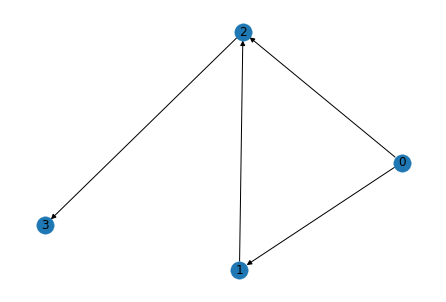

In [ ]:
# Simulation Parameters
nx.draw(G, with_labels = True)
num_reps = 1 #@param {type: "number"}

debug = 1 #@param {type:"slider", min:0, max:3, step:1}

MAX_TIME = 5000 #@param {type: "number"}

MAX_BIN = 100 #@param{type: "number"}

# NUM_BINS (J) acquired via get_num_bins(). Zero-indexed.
outgoing = get_outgoing_edges(G)
incoming = get_incoming_edges(outgoing)
NUM_BINS = get_num_bins(incoming) # USEFUL FOR GRAPH
OUTMAP = get_output_map(incoming, outgoing, NUM_BINS)

# NUM_NODES (N) acquired via get_num_nodes(). Zero-indexed.
NUM_NODES = get_num_nodes(G)

# Trials

In [ ]:
debug = 1 #@param {type:"slider", min:0, max:3, step:1}
seed0 = [12345, 12345, 12345, 12345, 12345, 12345]
rngStream.SetPackageSeed(seed0)

# est = Estimator(conf_pct, relative_precision, relative) # confidence percentile, relative precision
sim = SQN_Model(NUM_NODES, NUM_BINS, MAX_BIN, MAX_TIME, OUTMAP)
trials = []

MAX_TIME = 500
#include_state_history, include_throughput
include_state_history = True #@param {type:"boolean"}
include_throughput = True #@param {type:"boolean"}
include_activityrate = False #@param {type:"boolean"}
num_reps = 1

for rep in range(int(num_reps)):
  print(f"\n\nNow running repetition {rep}")
  # NOTE, to transition this into MAX_TIMESTEPS instead of MAX_TIME, add a non-zero fourth parameter to trial
  trial = sim.do_rep(include_state_history, include_throughput, include_activityrate)
  trials.append(trial)

Streaming output truncated to the last 5000 lines.
 Set a future timer for e0: 4861.383825633141
 New state: [[1], [1, 1], [1, 0, 31], [1, 0]]
 
Time 4861.357931353644, timesteps 24366
 Event e0 new output from node 0, tprime = 4861.383825633141
 Options: [(2, 0), (1, 0)], Selection: node 2 bin 0
 Set a future timer for e0: 4861.945405376881
 New state: [[1], [1, 1], [1, 1, 31], [1, 0]]
 
Time 4861.383825633141, timesteps 24367
 Event e1 new output from node 1, tprime = 4861.469709400391
 Options: [(2, 1)], Selection: node 2 bin 1
 Deactivated node 1
 Activated node 1
 Set a future timer for e1: 4861.485050813197
 New state: [[1], [1, 0], [1, 1, 32], [1, 0]]
 
Time 4861.469709400391, timesteps 24368
 Event e1 new output from node 1, tprime = 4861.485050813197
 Options: [(2, 1)], Selection: node 2 bin 1
 Deactivated node 1
 New state: [[1], [0, 0], [1, 1, 33], [1, 0]]
 
Time 4861.485050813197, timesteps 24369
 Event e0 new output from node 0, tprime = 4861.945405376881
 Options: [(2, 0)

## Display Results

In [ ]:
debug_trials =  0 #@param {type:"slider", min:0, max:3, step:1}

if debug_trials > 0:
  print("\nPrinting the Outputs")
  for trial_instance in trials:
    if include_state_history:
      print(f"State history {trial_instance[0]}")
      print("State breakdown")
      for unpack in trial_instance[0]:
        print(unpack)

    if include_throughput:
      print(f"Trial throughput: {trial_instance[1]}\n")
    
      


## Package JSON

In [ ]:
feature_list = []
# It automatically included the results of the trials. 
include_trials = True #@param{type: "boolean"}
if include_trials:
  feature_list.append(trials)

include_OUTMAP= True #@param{type: "boolean"}
if include_OUTMAP:
  feature_list.append(OUTMAP)

include_MAX_BIN = True #@param{type: "boolean"}
if include_MAX_BIN:
  feature_list.append(MAX_BIN)

include_incoming_edges = True #@param{type: "boolean"}
if include_incoming_edges:
  feature_list.append(incoming)

include_outgoing_edges = True #@param{type: "boolean"}
if include_outgoing_edges:
  feature_list.append(outgoing)

JSON_pkg = json.dumps(feature_list)

In [ ]:
print(JSON_pkg)
# Add this to github after

[[[[[[[1], [0, 0], [0, 1, 0], [0, 0]], 1.0317403105940641, 0], [[[1], [1, 0], [0, 1, 0], [0, 0]], 1.6186464061091286, 0], [[[1], [0, 0], [1, 0, 0], [0, 0]], 1.7561399952884715, 1], [[[1], [0, 0], [0, 0, 0], [1, 0]], 1.9145171053313015, 2], [[[1], [1, 0], [0, 0, 0], [1, 0]], 2.372019573211232, 0], [[[1], [0, 0], [0, 0, 1], [1, 0]], 2.5610886733286433, 1], [[[1], [0, 0], [1, 0, 0], [1, 0]], 2.738198348646346, 0], [[[1], [0, 0], [0, 0, 0], [1, 1]], 2.7401099329083096, 2], [[[1], [0, 0], [0, 0, 0], [1, 0]], 3.087771902469007, 3], [[[1], [0, 0], [0, 0, 0], [0, 0]], 3.293359629525825, 3], [[[1], [1, 0], [0, 0, 0], [0, 0]], 3.7357911559234602, 0], [[[1], [1, 0], [0, 1, 0], [0, 0]], 4.012001122044485, 0], [[[1], [1, 0], [0, 2, 0], [0, 0]], 4.571924683053788, 0], [[[1], [1, 1], [0, 2, 0], [0, 0]], 4.81902122171098, 0], [[[1], [1, 0], [1, 1, 0], [0, 0]], 4.889944157254342, 1], [[[1], [1, 0], [0, 1, 0], [1, 0]], 4.9035550340367795, 2], [[[1], [0, 0], [1, 0, 0], [1, 0]], 5.024413923665107, 1], [[[

In [ ]:
# Output to JSON file
with open("output.json", "w") as outfile:
    outfile.write(JSON_pkg)

# MM1 Verification

## Pracheta's MM1 Solution 

Variable Descriptions

* t is the time instant for which we want to compute the probability 

* k is the value for which you are trying to obtain the probability 

* lambda_ is the arrival rate

* mu_ is the service rate 

* i is the number of people in the system (both being serviced and currently in queue)  at time t = 0. 

In [ ]:
import numpy as np
import scipy.special 
from mpmath import nsum, inf

def p_L(k, t, lambda_, mu_, i):
    # Get the transient solution from https://en.wikipedia.org/wiki/M/M/1_queue
    
    # Constants
    rho = lambda_/mu_
    a = 2 * np.sqrt(lambda_ * mu_)

    outer_term = np.exp(-((lambda_ + mu_)*t))
    inner_term_1 = (rho**((k - i)/2)) * (scipy.special.iv(k - i, a * t))
    inner_term_2 = (rho**((k - i - 1)/2)) * scipy.special.iv(k + i + 1, a * t)

    def inf_sum_func(x):
        term = ((rho**(-x/2)) * scipy.special.iv(float(x), float(a*t)))
        return term

    infinite_sum = nsum(inf_sum_func, [k+i+2, inf])
    inner_term_3 = ((1 - rho)*(rho ** k)) * infinite_sum

    pmf = outer_term * (inner_term_1 + inner_term_2 + inner_term_3)
    return pmf

In [ ]:
def MM1_graph(time, queues):  
  # Constants for Pracheta's code
  mu_ = 0.5
  lambda_ = 0.5
  i = 0

  bins = set(queues)
  num_bins = int(max(bins))
  print(f"Bins of histogram: {bins}")
  print(f"Queue sizes: {queues}\n")

  # plt.hist(queues, density = 1, color ='green', label = "Percentage observed")
  plt.hist(queues, bins = num_bins, density = 1, color ='green', label = "Percentage observed")

  len_probability_vector = np.vectorize(p_L)
  probability_overlay = len_probability_vector([x for x in range(0, max(bins))], time, mu_, lambda_, i)
  probability_overlay = [float(x) for x in probability_overlay]

  plt.plot(probability_overlay, '--', color ='red', label = "True probabilities for bin sizes")
  plt.title(f"Empirical queue sizes versus true queue sizes\nTimesteps = {time}")
  plt.xlabel("Observed queue sizes")
  plt.ylabel("Probability")
  plt.legend()

In [ ]:
debug = 0 #@param {type:"slider", min:0, max:3, step:1}
seed0 = [12345, 12345, 12345, 12345, 12345, 12345]
rngStream.SetPackageSeed(seed0)

MAX_BIN = 100000 # 1000 This will never be reached
MAX_TIME = 200 # 200000 Never reached
MAX_TIMESTEPS = 200
num_reps = 10000
trials = []

for rep in range(int(num_reps)):
  sim = SQN_Model(NUM_NODES, NUM_BINS, MAX_BIN, MAX_TIME, OUTMAP)
  # sim.do_rep(include_state_history, include_throughput, include_activityrate)
  sim.do_rep(include_state_history, include_throughput, include_activityrate, MAX_TIMESTEPS)
  trial = sim.get_final_queue_size()
  trials.append(trial)

print(trials)


[0, 0, 0, 3, 3, 0, 0, 0, 3, 0, 0, 2, 0, 6, 0, 4, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 4, 1, 0, 0, 0, 1, 0, 0, 0, 0, 5, 3, 4, 0, 3, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 3, 0, 3, 1, 0, 0, 3, 1, 0, 3, 0, 0, 0, 0, 2, 1, 0, 1, 2, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 2, 0, 2, 5, 1, 0, 5, 3, 0, 0, 0, 2, 0, 0, 0, 0, 2, 4, 0, 2, 1, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 1, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 3, 0, 1, 1, 0, 0, 0, 0, 1, 0, 5, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 2, 2, 2, 1, 0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2, 3, 0, 5, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 

## MM1 Verification Graph

Bins of histogram: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18}
Queue sizes: [0, 0, 0, 3, 3, 0, 0, 0, 3, 0, 0, 2, 0, 6, 0, 4, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 3, 4, 1, 0, 0, 0, 1, 0, 0, 0, 0, 5, 3, 4, 0, 3, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 3, 0, 3, 1, 0, 0, 3, 1, 0, 3, 0, 0, 0, 0, 2, 1, 0, 1, 2, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 2, 0, 2, 5, 1, 0, 5, 3, 0, 0, 0, 2, 0, 0, 0, 0, 2, 4, 0, 2, 1, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 1, 4, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 3, 0, 1, 1, 0, 0, 0, 0, 1, 0, 5, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 2, 2, 2, 1, 0, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2, 3, 0, 5, 0, 0, 1, 0, 1, 0, 2

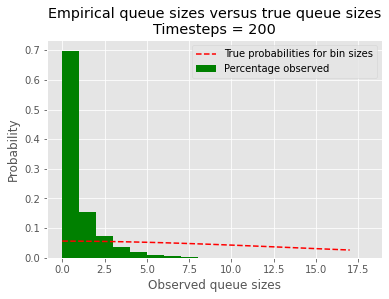

In [ ]:
MM1_graph(MAX_TIMESTEPS, trials)

# Playground


In [ ]:
debug = 1 #@param {type:"slider", min:0, max:3, step:1}

In [ ]:
if debug > 2:
  try:
    # Test state_swap
    S = [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0], [0, 0], [0, 0], [0, 0], [0]]
    S_prime = [[1, 2, 1, 0], [0, 0, 3, 2], [1, 5, 0, 3], [2, 0, 4], [1, 5], [3, 1], [0, 0], [6]]
    print(f"S: {S}, id = {id(S)}")
    print(f"S: {S_prime}, id = {id(S_prime)}")

    # This function changes s' to be equal to s without memory allocation. Used at the end of state transition steps.
    def state_swap(s:List, s_prime:List):
      if debug > 0:  # TO-DO: REMOVE ON CORRECT OUTPUT
        assertion_id = id(s)
      for index, x in enumerate(s_prime):
        for x_i in range(len(x)):
          s[index][x_i] = s_prime[index][x_i]
      if debug > 0:  # TO-DO: REMOVE ON CORRECT OUTPUT 
        assert(id(s) != id(s_prime)) 
        assert(id(s) == assertion_id)
    
    state_swap(S, S_prime)
    print(f"\nS: {S}, id = {id(S)}")
    print(f"S: {S_prime}, id = {id(S_prime)}")

    # Test get_output_map
    # Returns a list of (tuples) for every node's output. 
    # The first tuple item represents the incoming node for that edge, the second item represents the bin in that incoming node it would iterate.
    def get_output_map(incoming_edges, outgoing_edges, NUM_BINS):
      verbose_print(1, "\nOutput map function\n")
      verbose_print(2, "\nIncoming edges: ", incoming_edges, "\nOutgoing edges: ", outgoing_edges, "\n")
      
      outmap = [[] for x in range(len(outgoing_edges))]
      for out_index, node in enumerate(outgoing_edges):
        for out_edge_val in node:
          verbose_print(2, "\nOutput edge value:", out_edge_val)
          verbose_print(2, f"Incoming edges of node {out_edge_val} are: {incoming_edges[out_edge_val]}")

          bin_index = 0
          for in_edge in incoming_edges[out_edge_val]:
            verbose_print(3, "Cumulative (counting) bin index: ", bin_index)
            if in_edge == out_index:
              verbose_print(2, f"Incoming node {out_edge_val} has bin index {bin_index} corresponding to outgoing node {out_index}")
              break
            bin_index += 1
          if(bin_index >= 0):
            outmap[out_index].append((out_edge_val, bin_index))
      
      verbose_print(1, outmap)
      return outmap

    outgoing = get_outgoing_edges(G)
    incoming = get_incoming_edges(outgoing)
    num_bins = get_num_bins(incoming)
    outmap = get_output_map(incoming, outgoing, num_bins)

  except:
    print("Playground testing failed")

In [ ]:
c = [0, 1, 1, 5, 6]

check = True
for elements in c[1:]:
  print(elements)
  if elements < 1:
    check = False

print(check)

1
1
5
6
True


In [ ]:
A = [1,2,3,4,5,6,7,8,9,10]
B = []
for i in A:
  for j in A:
    for k in A:
      if i > j and j > k:
        B.append((i, j, k))

print(len(B))

120


## Estimator Model

In [ ]:
class Estimator:
    """ Computes point estimates and confidence intervals """
    def __init__(self, conf_pct, epsilon, relative):
        self.epsilon = epsilon # precison of CI
        self.relative = relative # relative or absolute precision
        self.k = 0  # number of values processed so far
        self.sum = 0.0  # running sum of values
        self.v = 0.0  # running value of (k-1)*variance
        self.z = norm.ppf(0.5 + (conf_pct / 200))  # CI normal quantile
        self.conf_str = str(conf_pct) + "%"  # string of form "xx%" for xx% CI
        self.observations = []
        
    def reset(self):
        self.k = 0
        self.sum = 0
        self.v = 0

    def process_next_val(self, value):
        self.k += 1
        if self.k > 1:
            diff = self.sum - (self.k - 1) * value
            self.v += diff/self.k * diff/(self.k-1)
        self.sum += value
        
    def get_next_val(self, value):
        self.observations.append(value)
        if not self.regenerative:
          self.observations_squared.append(value ** 2) # added for 1b part III

    def get_variance(self):
        return self.v/(self.k-1) if self.k > 1 else 0

    def get_mean(self):
        return self.sum/self.k if self.k >= 1 else 0

    def get_conf_interval(self):
        hw = self.z * math.sqrt(self.get_variance()/self.k)
        point_est = self.get_mean()
        c_low = point_est - hw
        c_high = point_est + hw
        rstr = "{0} Confidence Interval: [ {1:.4f}, {2:.4f} ]  (hw = {3:.4f})"
        return rstr.format(self.conf_str, c_low, c_high, hw)

## Estimator Parameters

In [ ]:
# Estimator Parameters
conf_pct= 95 #@param{type: "number"}
relative_precision = 0.01 #@param{type: "number"}
relative = True #@param{type: "boolean"}

## Planar graph/figure for Paper
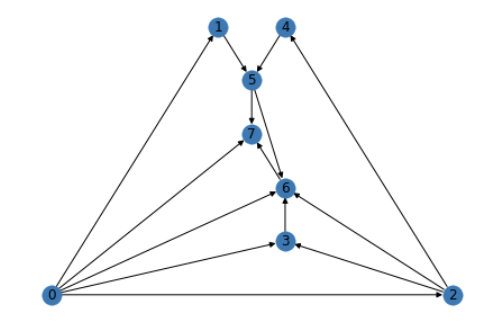